Modèle ARIMA avec Python – Prévisions de séries temporelles
===


Le modèle ARIMA (moyenne mobile intégrée autorégressive) avec Python donne la possibilité de faire des prévisions basées sur des observations historiques.

Une série temporelle peut être décomposée en 3 composantes:
- Tendance : Mouvement de hausse et de baisse des données au cours du temps sur une longue période (par exemple le prix de l’immobilier)
- Saisonnalité : Variance saisonnière (par exemple une augmentation de la demande de glace pendant l’été)
- Bruit : Des pics et des creux à intervalles aléatoires

Avant d’appliquer un modèle statistique sur une série temporelle, nous devons nous assurer qu’elle est stationnaire.
**La moyenne (hauteur moyenne des vagues), la variance (taille des vagues) et la covariance (écart entre vague) de la série ne doivent pas être fonction du temps !**

In [1]:
from tools import find_file

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1. Récupération des données et série temporelle stationnaire

In [3]:
df = pd.read_csv(find_file('airline_passengers.csv'), parse_dates=['Month'], index_col=['Month'])

df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


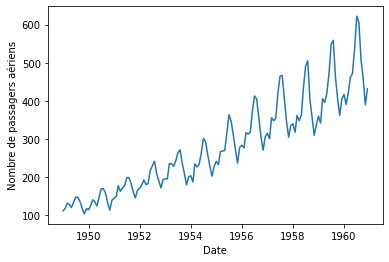

In [4]:
plt.xlabel('Date')
plt.ylabel('Nombre de passagers aériens')
plt.plot(df)

Il y a deux façons principales de déterminer si une série temporelle donnée est stationnaire:
- Statistiques roulantes : Tracer la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps (à l’œil nu, regardez si les lignes sont droites et parallèles à l’axe des x)
- Test de Dickey-Fuller augmenté (ADF) : La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

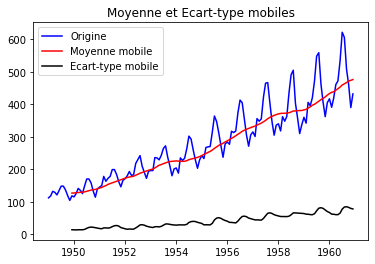

In [5]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

plt.plot(df, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

On voit bien que l'écart type et la moyenne augmentent dans le temps, on peut aussi le voir avec le second test : 

In [6]:
result = adfuller(df['Thousands of Passengers'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 0.8153688792060569
p-value : 0.9918802434376411
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [7]:
# stockons cela dans une fonction :
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries['Thousands of Passengers'])
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

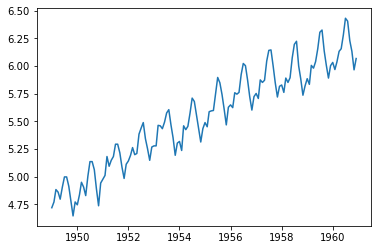

In [8]:
# Prendre le logarithme de la variable dépendante est un moyen simple de réduire le taux d’augmentation de la moyenne mobile :
df_log = np.log(df)
plt.plot(df_log)

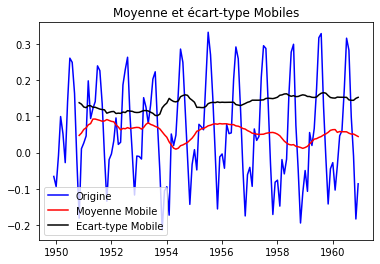

Statistiques ADF : -3.1629079913008726
p-value : 0.02223463000124292
Valeurs Critiques :
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [9]:
# Tentons de soustraire la moyenne mobile afin d'obtenir une courbe stationnaire :
rolling_mean = df_log.rolling(window=12).mean()

df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

Comme on peut le voir, après soustraction de la moyenne, la moyenne mobile et l’écart-type sont approximativement horizontaux. La p-value est inférieure au seuil de 0,05 et la statistique ADF est proche des valeurs critiques. Par conséquent, la série temporelle est stationnaire. D'autres techniques sont :
- la décroissance exponentielle :
```python
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

get_stationarity(df_log_exp_decay)
```
- le décalage temporel, soustrayons chaque point par celui qui l’a précédé :
```python
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)

get_stationarity(df_log_shift)
```

## 2. Modèles temporels

* **Modèle Auto-Régressif (AR)** : Les modèles auto-régressifs fonctionnent en partant du principe que les valeurs passées ont un effet sur les valeurs actuelles. 
* **Modèle de la Moyenne Mobile (MA)** : la valeur de la variable dépendante du jour en cours dépend des termes d’erreur des jours précédents.
* **Modèle de la Moyenne Mobile Auto-Régressive (ARMA)** : simplement la combinaison des 2 précédents modèles AR et MA.
* **Modèle de la Moyenne Mobile Auto-Régressive Intégrée (ARIMA)** : Le modèle ARIMA ajoute une différence à un modèle ARMA. La différenciation soustrait la valeur actuelle de la précédente et peut être utilisée pour transformer une série temporelle en une série stationnaire. 
> Par exemple, la différenciation du premier ordre traite des tendances linéaires et utilise la transformation zi = yi – yi-1. La différenciation du second ordre traite des tendances quadratiques et utilise une différence du premier ordre sur une différence du premier ordre, à savoir zi = (yi – yi-1) – (yi-1 – yi-2), et ainsi de suite.

Trois entiers (p, d, q) sont généralement utilisés pour paramétrer les modèles ARIMA :
- p : nombre de termes autorégressifs (ordre AR)
- d : nombre de différences non saisonnières (ordre de différenciation)
- q : nombre de termes moyens mobiles (ordre MA)



Fonction d’Auto-Corrélation (ACF) : La corrélation entre les observations à l’instant actuel et les observations à tous les instants précédents. Nous pouvons utiliser l’ACF pour déterminer le nombre optimal de termes MA. Le nombre de termes détermine l’ordre du modèle.

Fonction d’Auto-Corrélation Partielle (PACF) : Le PACF exprime la corrélation entre les observations faites à deux moments dans le temps tout en tenant compte de l’influence éventuelle d’autres points de données. Nous pouvons utiliser le PACF pour déterminer le nombre optimal de termes à utiliser dans le modèle AR. Le nombre de termes détermine l’ordre du modèle.

Pour revenir à notre exemple, nous pouvons créer et ajuster un modèle ARIMA avec un AR d’ordre 2, une différence d’ordre 1 et un MA d’ordre 2 :import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.w

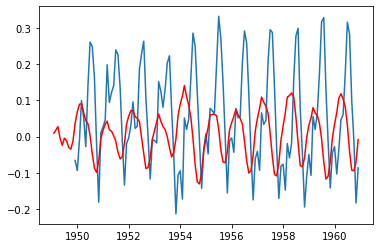

In [10]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_minus_mean)
plt.plot(results.fittedvalues, color='red')

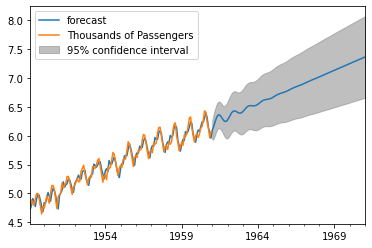

In [11]:
fig = results.plot_predict(1,264)